# Processing the 68k PBMC dataset for use with feature selection algorithms

Following the tutorial at: https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

In [2]:
from scipy.stats import rankdata
import scipy.sparse as spsp

Apparently, changing LD_LIBRARY_PATH might not work while you are in a notebook session.  See: https://github.com/ipython/ipython/issues/3992#issuecomment-58560700

You need to put it in your configuration file.  See: https://github.com/jupyter/notebook/issues/1290

So the next two cells are wrong and bad and you shouldn't run them

In [3]:
import os
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":/home/ahsvargo/lib"
os.environ['LD_LIBRARY_PATH']

'/home/ahsvargo/lib:/sw/arcts/centos7/hpc-utils/lib:/sw/arcts/centos7/R/3.3.3/lib64/R/lib:/sw/arcts/centos7/openmpi/1.10.2-gcc-4.8.5/lib:/home/ahsvargo/lib:/home/ahsvargo/lib:/home/ahsvargo/lib'

In [4]:
%env LD_LIBRARY_PATH=/sw/arcts/centos7/hpc-utils/lib:/sw/arcts/centos7/R/3.3.3/lib64/R/lib:/sw/arcts/centos7/openmpi/1.10.2-gcc-4.8.5/lib:/home/ahsvargo/lib

env: LD_LIBRARY_PATH=/sw/arcts/centos7/hpc-utils/lib:/sw/arcts/centos7/R/3.3.3/lib64/R/lib:/sw/arcts/centos7/openmpi/1.10.2-gcc-4.8.5/lib:/home/ahsvargo/lib


Don't know why /home/ahsvargo/lib appears so many times, but I think that it works now

In [3]:
import os
os.environ['LD_LIBRARY_PATH']

'/home/ahsvargo/lib:/sw/arcts/centos7/hpc-utils/lib:/sw/arcts/centos7/R/3.3.3/lib64/R/lib:/sw/arcts/centos7/openmpi/1.10.2-gcc-4.8.5/lib:/home/ahsvargo/lib:/home/ahsvargo/lib'

In [6]:
"libigraph.so.0" in os.listdir("/home/ahsvargo/lib")

True

In [4]:
import louvain

In [8]:
import subprocess
r = subprocess.check_output('jupyter --config-dir',shell=True) 
print(r)

b'/home/ahsvargo/.jupyter\n'


Read in the initial Zheng data

In [25]:
%%time
path= "."
adata = sc.read("matrix.mtx", cache=True).T
adata.var_names = pd.read_csv('genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv('barcodes.tsv', header=None)[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
CPU times: user 3.27 s, sys: 391 ms, total: 3.66 s
Wall time: 3.68 s


In [26]:
adata.var_names_make_unique()

In [27]:
adata.X.shape

(68579, 32738)

In [28]:
adata.obs['bulk_labels'] = pd.read_csv('./zheng17_bulk_lables.txt', header=None)[0].values

The following labels are generated and saved further down in this notebook:

In [29]:
adata.obs['louv_labels'] = pd.Series( [str(a) for a in np.load('./zheng17_yVec_lvals.npz')['y']], dtype="category", index=adata.obs.index)

In [30]:
lookup = dict(zip(np.unique(adata.obs['bulk_labels'].values), range(11)))
lookup

{'CD14+ Monocyte': 0,
 'CD19+ B': 1,
 'CD34+': 2,
 'CD4+ T Helper2': 3,
 'CD4+/CD25 T Reg': 4,
 'CD4+/CD45RA+/CD25- Naive T': 5,
 'CD4+/CD45RO+ Memory': 6,
 'CD56+ NK': 7,
 'CD8+ Cytotoxic T': 8,
 'CD8+/CD45RA+ Naive Cytotoxic': 9,
 'Dendritic': 10}

In [31]:
sc.logging.print_memory_usage()

Memory usage: current 2.86 GB, difference +0.57 GB


In [9]:
sc.pp.log1p(adata, copy=True).write('./write/zheng17_raw.h5ad')

In [32]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count

CPU times: user 937 ms, sys: 123 ms, total: 1.06 s
Wall time: 1.06 s


In [34]:
adata.X.shape

(68579, 20387)

In [12]:
# write the full data to a file for reading with other methods
adata.write("./write/raw_data_all_nz_genes_with_clusters.h5ad")

In [ ]:
adata.X.shape

## Look at sparsity of columns

The theoretical results that motivated the devlopment of RankCorr only held if the data was sparse.  How sparse is the data overall?

Skip this section if you are only interested in preprocessing and generating a Louvain clustering.

In [ ]:
sparseTest = adata.X.tocsc()

In [72]:
sparseTest.eliminate_zeros()

In [73]:
%%time
colNums = []
for col in range(sparseTest.shape[1]):
    colNums.append(sparseTest[:,col].data.shape[0])

CPU times: user 4.21 s, sys: 0 ns, total: 4.21 s
Wall time: 4.21 s


In [74]:
colNums = np.array(colNums)

In [75]:
import plotly.graph_objs as go
from plotly.offline import plot, iplot, init_notebook_mode

In [76]:
init_notebook_mode()

Plot number of reads in order

In [78]:
traces = [go.Scatter( x=list(range(colNums.shape[0])), y=np.sort(colNums))]
iplot(traces)

Check also the orignal sparsity of the high dispersion genes.  You need to have run the below code for this first

In [55]:
adata = adata[:, filter_result.gene_subset]  # filter genes

In [58]:
sparseTest = adata.X.tocsc()
sparseTest.eliminate_zeros()

In [59]:
%%time
colNums = []
for col in range(sparseTest.shape[1]):
    colNums.append(sparseTest[:,col].data.shape[0])
    
colNums = np.array(colNums)

CPU times: user 1.05 s, sys: 246 µs, total: 1.05 s
Wall time: 1.05 s


still a large maximum

In [60]:
colNums.max()

68528

In [61]:
traces = [go.Scatter( x=list(range(colNums.shape[0])), y=np.sort(colNums))]
iplot(traces)

The curve looks pretty much the same, which is (I suppose) what the filter genes by dispersion binning method actually accomplishes

The question is: which genes are we selecting?  Is it often the genes with high expression?

## Preprocess the data

Following the scanpy tutorial found at https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We use the 1000 most variable genes for the generation of the Louvain clustering and 5000 for the ZhengFilt data set.

In [35]:
%%time
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell

CPU times: user 615 ms, sys: 213 ms, total: 828 ms
Wall time: 827 ms


In [36]:
%%time
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 2.57 GB, difference -0.29 GB
CPU times: user 644 ms, sys: 1.11 s, total: 1.75 s
Wall time: 1.75 s


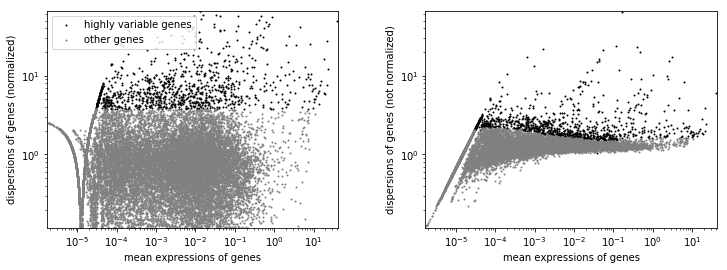

In [37]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

In [38]:
filter_result.gene_subset.shape

(20387,)

In [39]:
adata

AnnData object with n_obs × n_vars = 68579 × 20387 
    obs: 'bulk_labels', 'louv_labels', 'n_counts'
    var: 'n_counts'

In [40]:
adata.var.index

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.3', 'RP11-206L10.2',
       'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C', 'RP11-54O7.1',
       'SAMD11',
       ...
       'AC145212.1', 'MGC39584', 'AC011043.1', 'ZNF84-1', 'AL592183.1',
       'AC011841.1', 'AL354822.1', 'KIR2DL2', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=20387)

In [41]:
%%time
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata)  # center and make the data have unit variance

CPU times: user 676 ms, sys: 116 ms, total: 793 ms
Wall time: 791 ms


## Create PCAs

In [42]:
sc.tl.pca(adata, n_comps=55)
sc.logging.print_memory_usage()

Memory usage: current 1.52 GB, difference -1.05 GB


## Generate neighbours and umap

In [43]:
%%time
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50)
sc.logging.print_memory_usage()

Memory usage: current 1.56 GB, difference +0.05 GB
CPU times: user 42.3 s, sys: 17.5 s, total: 59.8 s
Wall time: 36.1 s


In [44]:
%%time
sc.tl.umap(adata)
sc.logging.print_memory_usage()

Memory usage: current 1.57 GB, difference +0.00 GB
CPU times: user 2min 29s, sys: 2min 30s, total: 4min 59s
Wall time: 2min 20s


In [45]:
adata

AnnData object with n_obs × n_vars = 68579 × 1000 
    obs: 'bulk_labels', 'louv_labels', 'n_counts'
    var: 'n_counts'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Create louvain clustering and visualize

In [46]:
%%time
sc.tl.louvain(adata, resolution=0.3)
sc.logging.print_memory_usage()

Memory usage: current 1.57 GB, difference +0.00 GB
CPU times: user 16.4 s, sys: 372 ms, total: 16.8 s
Wall time: 16.7 s


In [47]:
adata.obs['lvals'] = np.array(adata.obs['louvain'].values)

saving figure to file ./figures/umapzheng17-lvals-umap.pdf


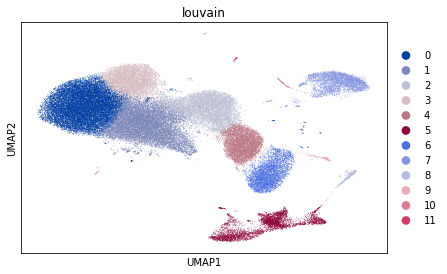

In [61]:
sc.pl.umap(adata, color='louvain', save="zheng17-lvals-umap.pdf")

saving figure to file ./figures/umapzheng17-bulk-umap.pdf


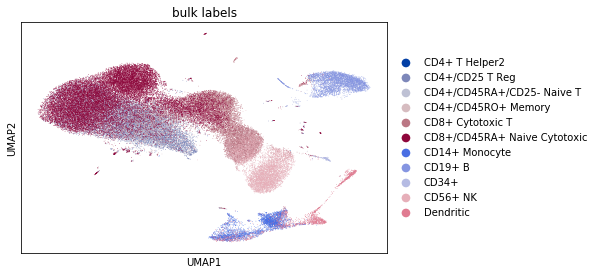

In [59]:
sc.pl.umap(adata, color='bulk_labels', save="zheng17-bulk-umap.pdf")

In [58]:
?sc.pl.umap

In [50]:
adata

AnnData object with n_obs × n_vars = 68579 × 1000 
    obs: 'bulk_labels', 'louv_labels', 'n_counts', 'louvain', 'lvals'
    var: 'n_counts'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'bulk_labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [51]:
lVals = np.array(adata.obs['louvain'].values).astype(int)

In [54]:
louvLabels = np.array(adata.obs['louv_labels'].values).astype(int)

In [57]:
np.all(lVals==louvLabels)

True

The Louvain clustering is consistent between trials - the random number generator is seeded by scanpy, presumably.

In [50]:
print(adata.obs['louvain'].values[10:20])

[1, 0, 1, 1, 2, 2, 1, 2, 0, 0]
Categories (12, object): [0, 1, 2, 3, ..., 8, 9, 10, 11]


In [72]:
np.savez("zheng17_yVec_lvals", y=lVals)

Compute the clustering metrics

In [62]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

In [64]:
yVec = np.array([lookup[val] for val in adata.obs['bulk_labels'].values])

See the `clustering_metrics.ipynb` file for the final computation of these values - this notebook was created using an older version of sklearn

In [65]:
adjusted_rand_score(yVec, lVals)

0.3452740605205953

In [71]:
adjusted_mutual_info_score(yVec, lVals)

0.5537026562920173

In [67]:
fowlkes_mallows_score(yVec, lVals)

0.46243349161693037

In [70]:
sklearn.__version__

'0.19.1'

In [69]:
import sklearn

## Play around with matplotlib if you get stuck

When working with n=20 neighbours and 50 pcs, the umap sc.pl.umap function produces some screwy results (in my current version of scanpy).

In these cases, you can get your hands on the graph in the following manner.  References for this:

* [Here](https://realpython.com/python-matplotlib-guide/) is a nice but kind of slow tutorial for how matplotlib works over all.  There is a nice figure ([here](https://files.realpython.com/media/fig_map.bc8c7cabd823.png)) that describes how the Figure, Axes, and Axis objects are all related.  That's the important bit to understand here.

* [The axes class documentation](https://matplotlib.org/api/axes_api.html). 
    * You need to input an axes object to the umap function.  The axes object already needs to be associated with a figure: it is basically impossible to take an existing axes object and put it into a new figure.  See [here](https://stackoverflow.com/questions/40742896/how-to-perform-subplot-from-existing-axes-with-matplotlib).  
    * The axes object is the thing that corresponds to all of the data and the formatting, etc.  You will use it to set limits on axes, the number of tick marks that you see, etc.  All of those functions are found in the axes class documentation.
* [The Figure class documentation](https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html).  This is how you control things like the size of the figure and how to display, etc.  You can also make subplots of one figure, but don't worry about that I think.
    
* [The matplotlib how-to tutorial](https://matplotlib.org/faq/howto_faq.html).  Scroll down a little bit to see how to put a subplot into the plot and get the corresponding figure and axes objects.  See also the `subplots` function.


In [24]:
import matplotlib.pyplot as plt

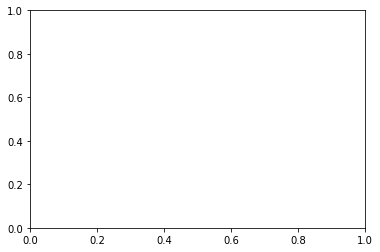

In [25]:
fig, ax = plt.subplots(1, 1)

In [26]:
sc.pl.umap(adata, color='louvain', ax=ax)

In [27]:
ax.set_xlim((-9,12))

(-9, 12)

In [28]:
ax.set_aspect(aspect=0.4)

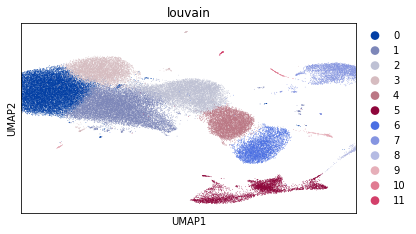

In [29]:
fig

In [30]:
ax.get_ylim()

(-16.164440855558155, 13.656329750252807)

For some reason, the `set_size_inches` method doesn't work on a figure:

In [31]:
fig.set_size_inches(10,10)

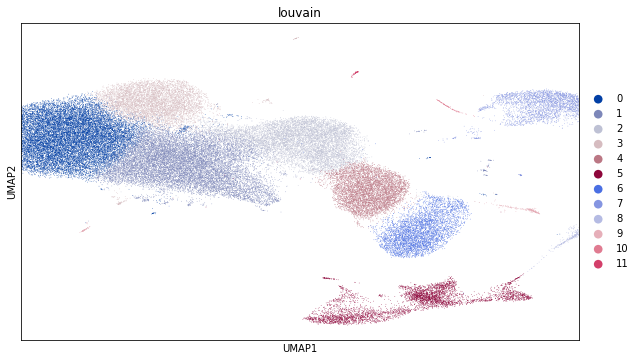

In [32]:
fig

## Attempt restricting to the clusters provided with the 10x download

Our analysis here shows that this is quite different from the clustering obtained in the paper... Thus, I have decided to proceed with louvain clustering, which looks pretty good (though still different from the paper)

In [46]:
why = pd.read_csv("../../analysis_csv/kmeans/10_clusters/clusters.csv")

In [47]:
clustVec = why["Cluster"].values
cells = why["Barcode"].values

In [48]:
clusteredData = adata[cells]

In [49]:
clusteredData.obs['kmeans'] = [str(clust) for clust in clustVec]

In [21]:
%%time
sc.tl.tsne(clusteredData)
sc.logging.print_memory_usage()

Memory usage: current 1.04 GB, difference +0.21 GB
CPU times: user 6min 36s, sys: 844 ms, total: 6min 37s
Wall time: 6min 38s


... storing 'kmeans' as categorical


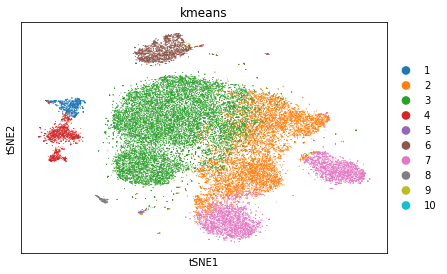

In [36]:
sc.pl.tsne(clusteredData, color='kmeans')

We appear to have merged clusters 2 and 4 from the paper.  Also the NK cluster is much larger (I don't think that this is completely wrong, judging by the bulk labels) and the dendritic cell/monocytes cluster looks strangely separated (though this coupld easily be a function of the fact that we are using only 40000 cells in this clustering).

These aren't terrible changes; I'm just bothered by the fact that this is clearly some random person's 10 cluster kmeans clustering on some subset of the cells.  I would guess that it was generated simply for the visualization on the 10x website.  Thus, I will re-run some clustering myself.

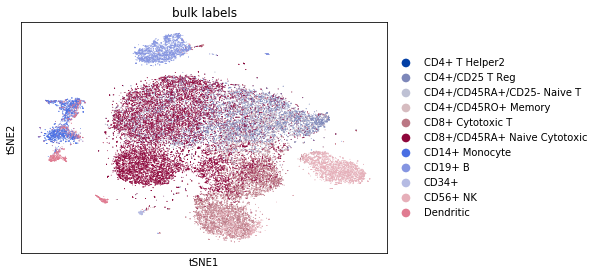

In [38]:
sc.pl.tsne(clusteredData, color='bulk_labels')

In [51]:
clusteredData

AnnData object with n_obs × n_vars = 40000 × 1000 
    obs: 'bulk_labels', 'n_counts', 'louvain', 'lvals', 'kmeans'
    var: 'n_counts'
    uns: 'bulk_labels_colors', 'lvals_colors', 'louvain', 'pca', 'neighbors', 'kmeans_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [54]:
adata.uns['louvain_colors'][:10]= clusteredData.uns['kmeans_colors']

... storing 'kmeans' as categorical


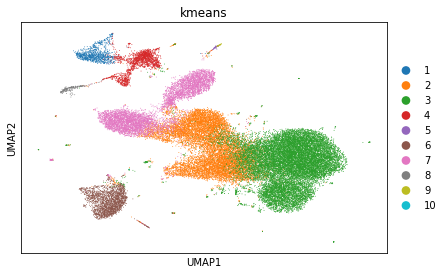

In [50]:
sc.pl.umap(clusteredData, color='kmeans')

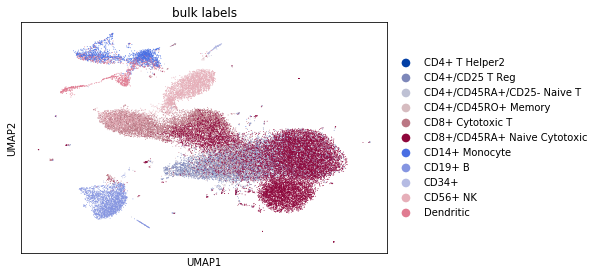

In [46]:
sc.pl.umap(clusteredData, color='bulk_labels')

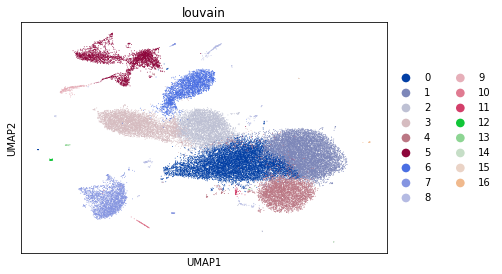

In [47]:
sc.pl.umap(clusteredData, color='louvain')

Make a copy of the raw data at the high dispersion genes for reading into scVI.  Not sure how much memory it will take otherwise

In [27]:
adata = adata[:, filter_result.gene_subset]  # filter genes

In [28]:
adata.write("./write/raw_data_5000_genes.h5ad")

## Make folds for the data and save the individual folds

We're doing this for scVI

In [53]:
import sys
sys.path.append('/home/ahsvargo/xvalid')

In [54]:
from picturedrocks import Rocks
from picturedrocks.performance import FoldTester, PerformanceReport, NearestCentroidClassifier

In [29]:
np.unique(adata.obs['bulk_labels'].values).shape

(11,)

In [30]:
lookup = dict(zip(np.unique(adata.obs['bulk_labels'].values), range(11)))
lookup

{'CD14+ Monocyte': 0,
 'CD19+ B': 1,
 'CD34+': 2,
 'CD4+ T Helper2': 3,
 'CD4+/CD25 T Reg': 4,
 'CD4+/CD45RA+/CD25- Naive T': 5,
 'CD4+/CD45RO+ Memory': 6,
 'CD56+ NK': 7,
 'CD8+ Cytotoxic T': 8,
 'CD8+/CD45RA+ Naive Cytotoxic': 9,
 'Dendritic': 10}

In [63]:
yVec = np.array([lookup[val] for val in adata.obs['bulk_labels'].values])

In [67]:
data = Rocks(adata.X, yVec)

In [68]:
ft = FoldTester(data)

In [63]:
#ft.makefolds(k=5, random=True)
#ft.savefolds("./zheng17-5folds.npz")

In [69]:
ft.loadfolds("./zheng17-5folds.npz")

In [70]:
# for the louvain clustering
data = Rocks(adata.X, lVals)
ft = FoldTester(data)
ft.makefolds(k=5, random=True)
ft.savefolds("./zheng17-5folds-lvals.npz")

In [37]:
data.sparse

True

Save each of the folds for input into scVI.  Lots of disk storage required, but whatever.

In [40]:
[fold.shape for fold in ft.folds]

[(13716,), (13716,), (13716,), (13716,), (13715,)]

In [48]:
for i, fold in enumerate(ft.folds):
    mask = np.zeros(data.N, dtype='bool')
    mask[fold] = True
    
    fname = "zheng17_raw_5000_genes_fold{}".format(i)
    print(fname)
    adata[~mask].write("./write/" + fname + ".h5ad")
    currY = yVec[~mask]
    np.savez("./write/" + fname + "_yVec", y=yVec)

zheng17_raw_5000_genes_fold0
zheng17_raw_5000_genes_fold1
zheng17_raw_5000_genes_fold2
zheng17_raw_5000_genes_fold3
zheng17_raw_5000_genes_fold4


In [51]:
spsp.save_npz("zheng17_raw_5000_genes", adata.X)

In [52]:
np.savez("zheng17_yVec", y=yVec)